<a href="https://colab.research.google.com/github/ahmergit/projects/blob/main/Podcast_generater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-groq langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain_google_genai tavily-python wikipedia google-generativeai

In [ ]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

In [ ]:
import os
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-project2"

In [ ]:
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [ ]:
import operator
from datetime import datetime
from typing import Any, Annotated, List, Dict
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from IPython.display import Image, display, Markdown

In [ ]:
from langchain_core.tools import tool
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage

In [ ]:
from langchain_groq import ChatGroq
def get_model(model:str="Agent_test", temp:float=0.1, max_tokens:int=100):
  """Get model from Groq"""
  model = ChatGroq(
        model="llama-3.1-70b-versatile",
        temperature=temp,
        max_tokens=max_tokens,
        api_key=GROQ_API_KEY,
        # max_input_tokens=5000
    )
  return model

In [ ]:
llm= get_model()
llm.invoke([HumanMessage(content="What is Attention in human cognition")])

AIMessage(content='Attention is a fundamental aspect of human cognition that enables us to selectively focus on certain stimuli, tasks, or mental processes while ignoring others. It is a complex cognitive process that involves the allocation of limited mental resources to prioritize and process relevant information.\n\nAttention serves several purposes:\n\n1. **Filtering out irrelevant information**: Attention helps us to filter out distractions and irrelevant information, allowing us to focus on the most important stimuli or tasks.\n2. **Prioritizing information**: Attention enables us to prioritize information based', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 41, 'total_tokens': 141, 'completion_time': 0.4, 'prompt_time': 0.009183181, 'queue_time': 0.28464928500000003, 'total_time': 0.409183181}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_b6828be2c9', 'finish_reason': 'length', 'logprobs': None}, id='ru

In [ ]:
 # Create the model Google Gemini
# llm2: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
#       model = "gemini-1.5-flash",
#       temperature = 0.21,
#       api_key=GEMINI_API_KEY,
#       top_p = 0.95,
#       top_k = 64,
#       max_output_tokens = 5000,
#       response_mime_type= "text/plain"

#  )

In [ ]:
# llm2.invoke([HumanMessage(content="hi")])

In [ ]:
# Create the model Google Gemini
import google.generativeai as genai
generation_config = {
  "temperature": 0.21,
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 5000,
  "response_mime_type": "text/plain",
}
genai.configure(api_key=GEMINI_API_KEY)

model = genai.GenerativeModel(
  model_name="gemini-1.5-flash",
  generation_config=generation_config,
)
podcast_model = model.start_chat()

In [ ]:
from langgraph.graph import MessagesState

In [ ]:
class StateAgent(MessagesState):
  topic:str
  keywords: list[str]
  subtopics: list[str]
  max_num_turns: int # Number turns of conversation
  context: Annotated[list, operator.add]
  section: str
  sections: list[str]


In [ ]:
class keywords(BaseModel):
    """Schema for keywords output"""
    keys: list[str] = Field(description="List of at least 3 keywords related to the topic")

gpt_keywords = get_model("Agent_test",0.1, 50)
model_keywords = gpt_keywords.with_structured_output(keywords)

In [ ]:
class Subtopics(BaseModel):
    """Answer with at least 3 subtopics related to the topic"""
    subtopics: list[str] = Field(description="list of at least 3 subtopics related to the topic")

class Structure(BaseModel):
    """Structure of the podcast having in account the topic and the keywords"""
    subtopics: list[str] = Field(description="3 subtopics that we will review in the podcast related to the Topic and the Keywords")

gpt_structure = get_model("Agent_test",0.3, 800)
model_structure = gpt_structure.with_structured_output(Structure)

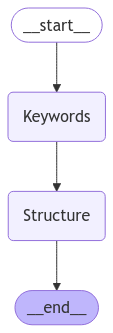

In [ ]:
import time

def get_keywords(state: StateAgent):
  topic = state['topic']
  messages = [SystemMessage(content="You task is to generate 3 relevant words about the following topic: " + topic)]

  # Add a delay of 5 seconds
  time.sleep(5)

  message = model_keywords.invoke(messages)
  return {'keywords': message.keys}

def get_structure(state: StateAgent) -> Dict[str, List[str]]:
  topic = state['topic']
  keywords = state['keywords']
  messages = [SystemMessage(content="You task is to generate 3 subtopics to make a podcast about the following topic: " + topic +"and the following keywords:" + " ".join(keywords))]
  message = model_structure.invoke(messages)
  return { "subtopics": message.subtopics}

plan_builder = StateGraph(StateAgent)

plan_builder.add_node("Keywords", get_keywords)
plan_builder.add_node("Structure", get_structure)
plan_builder.add_edge(START, "Keywords")
plan_builder.add_edge("Keywords", "Structure")
plan_builder.add_edge("Structure", END)

graph_plan = plan_builder.compile()

# View
display(Image(graph_plan.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
graph_plan.invoke({"topic": "What is Attention in human cognition"})

{'messages': [],
 'topic': 'What is Attention in human cognition',
 'keywords': ['cognitive', 'focus', 'perception'],
 'subtopics': ['The Neuroscience of Attention: How the Brain Focuses',
  'The Role of Perception in Attention: How We Filter Information',
  'Improving Cognitive Focus: Strategies for Enhancing Attention'],
 'context': []}

In [ ]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

podcast_gpt = get_model(max_tokens= 500)
structured_llm = podcast_gpt.with_structured_output(SearchQuery)

In [ ]:
question_instructions = """You are the host of a popular podcast and you are tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {topic}

Begin by introducing the topic that fits your goals, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help"

Remember to stay in character throughout your response"""

In [ ]:
def generate_question(state: StateAgent):
    """ Node to generate a question """

    # Get state
    topic = state["topic"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(topic=topic)
    question = podcast_gpt.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

In [ ]:
search_instructions = SystemMessage(content=f"""You will be given a conversation between a host of a popular podcast and an expert.
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [ ]:
def search_web(state: StateAgent):
    """ Retrieve docs from web search """

    # Search query
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    tavily_search = TavilySearchResults(max_results = 2)
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [ ]:
def search_wikipedia(state: StateAgent):
    """ Retrieve docs from wikipedia """

    # Search query
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=1).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [ ]:
answer_instructions = """You are an expert being interviewed by a popular podcast host.
Here is the analyst's focus area: {topic}.
Your goal is to answer a question posed by the interviewer.
To answer the question, use this context:
{context}
When answering questions, follow these steps

1. Use only the information provided in the context.

2. Do not introduce outside information or make assumptions beyond what is explicitly stated in the context.

3. The context includes sources on the topic of each document.

4. Make it interesting."""

In [ ]:
def generate_answer(state: StateAgent):

    """ Node to answer a question """

    # Get state
    topic = state["topic"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(topic=topic, context=context)
    answer = podcast_gpt.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

In [ ]:
from langchain_core.messages import get_buffer_string

In [ ]:
def save_podcast(state: StateAgent):

    """ save_podcast """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    state["section"] = interview

    # Save to interviews key
    return {"sections": interview}

In [ ]:
def route_messages(state: StateAgent, name: str="expert"):
    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
      # Save messages buffer to 'section' key before proceeding to "Save Podcast" node
      state["section"] = get_buffer_string(messages)
      return "Save podcast"

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    if len(messages) >= 2:
        last_question = messages[-2]

        if "Thank you so much for your help" in last_question.content:
            # Save messages buffer to 'section' key before proceeding to "Save Podcast" node
            state["section"] = get_buffer_string(messages)
            return 'Save podcast'
    # If conditions are not met, still execute "Save podcast" for debugging
    state["section"] = get_buffer_string(messages)
    return "Save podcast"

In [ ]:
section_writer_instructions = """You are an expert technical writer.

Your task is to create an interesting, easily digestible section of a podcast based on an interview.

1. Analyze the content of the interview

2. Create a script structure using markdown formatting

3. Make your title engaging based upon the focus area of the analyst:
{focus}

4. For the conversation:
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Mention turns of "Interviewer" and "Expert"
- Aim for approximately 800 words maximum

5. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: StateAgent):
    """Node to answer a question"""

    # Debugging: Print the state object
    print("State passed to write_section:", state)

    # Check if 'section' exists
    if "section" not in state:
        raise KeyError("The key 'section' is missing from the state object.")

    # Access state values
    section = state.get("section", "No section content provided.")
    topic = state.get("topic", "Unknown topic")

    # Create system message and call model
    system_message = section_writer_instructions.format(focus=topic)
    section_res = podcast_model.send_message(
        system_message + f" Use this source to write your section: {section}"
    )

    # Append to sections list
    return {"sections": [section_res.text]}



In [ ]:
interview_builder = StateGraph(StateAgent)
interview_builder.add_node("Keywords", get_keywords)
interview_builder.add_node("Structure", get_structure)
interview_builder.add_node("Host question", generate_question)
interview_builder.add_node("Web research", search_web)
interview_builder.add_node("Wiki research", search_wikipedia)
interview_builder.add_node("Expert answer", generate_answer)
interview_builder.add_node("Save podcast", save_podcast)
interview_builder.add_node("Write script", write_section)

# Flow
interview_builder.add_edge(START, "Keywords")
interview_builder.add_edge("Keywords", "Structure")
interview_builder.add_edge("Structure", "Host question")
interview_builder.add_edge("Host question", "Web research")
interview_builder.add_edge("Host question", "Wiki research")
interview_builder.add_edge("Web research", "Expert answer")
interview_builder.add_edge("Wiki research", "Expert answer")
interview_builder.add_conditional_edges("Expert answer", route_messages,['Host question','Save podcast'])
interview_builder.add_edge("Save podcast", "Write script")
interview_builder.add_edge("Write script", END)

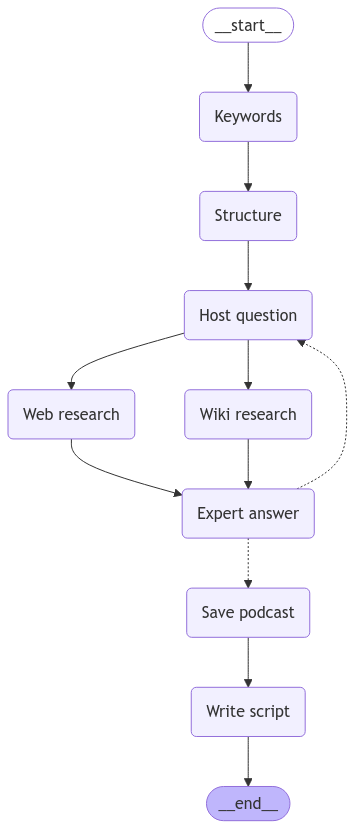

In [ ]:
# Interview
memory = MemorySaver()
podcast_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Create podcast")

# View
display(Image(podcast_graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = [HumanMessage("So you said you were writing an article about Attention in human cognition?")]
thread = {"configurable": {"thread_id": "1"}}

# Ensure 'section' key is passed
input_data = {
    "topic": "What is Attention in human cognition",
    "messages": messages,
    "max_num_turns": 2,
    "section": "This is the section content"
}

interview = podcast_graph.invoke(input_data, thread)
Markdown(interview['sections'][0])


State passed to write_section: {'messages': [HumanMessage(content='So you said you were writing an article about Attention in human cognition?', additional_kwargs={}, response_metadata={}, id='4aeb1a3c-0764-46ac-b751-b8c7e60b0b7f'), AIMessage(content="No, actually I'm the host of a popular podcast, and today we're going to dive into the fascinating topic of Attention in human cognition. I'm excited to have Dr. Rachel Kim, a renowned cognitive neuroscientist, joining me to share her expertise on this subject.\n\nWelcome to the show, Dr. Kim. I'm thrilled to have you here. \n\nTo start, I'd like to ask: What's one common misconception about attention that you think people should know, and how does it actually work in our brains?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 108, 'prompt_tokens': 198, 'total_tokens': 306, 'completion_time': 0.432, 'prompt_time': 0.023711378, 'queue_time': 0.018691301999999996, 'total_time': 0.455711378}, 'model_name': 'll

# Decoding Attention: The Mind's Spotlight

**Podcast Section Script**

**(Intro Music fades)**

**Interviewer:** Welcome back to "Brainwaves," everyone! Today, we delve into the fascinating world of human attention with Dr. Anya Sharma, a leading cognitive neuroscientist. Dr. Sharma, thank you for joining us.

**Expert:**  My pleasure! It's exciting to discuss this complex yet crucial aspect of human experience.

**Interviewer:**  Let's start with the basics.  Many people think of attention as simply focusing on something. But your research suggests it's far more nuanced than that. Can you elaborate?

**Expert:** Absolutely.  The common understanding is quite simplistic.  Attention isn't a single, unified process.  Instead, think of it as a family of processes, each contributing to our ability to select, enhance, and maintain focus on specific information while filtering out distractions.  My work highlights the crucial role of *predictive coding* in this process.

**Interviewer:** Predictive coding? That's a new one for me. Can you explain how that works in relation to attention?

**Expert:**  Imagine your brain constantly generating internal models of the world – predictions about what you're likely to experience next. These predictions aren't just passive; they actively shape what you attend to.  Your brain is constantly comparing incoming sensory information to these predictions.  When there's a mismatch – a prediction error – that's what grabs your attention.  It's like a spotlight illuminating the unexpected.

**Interviewer:** That's incredibly insightful! So, essentially, our attention isn't just passively drawn to stimuli; it's actively searching for discrepancies between our expectations and reality?

**Expert:** Precisely.  This explains why we're so easily distracted by novel or surprising events.  They violate our internal models, triggering a surge of attentional resources.  It also helps explain why we can sometimes miss obvious things – if they fit perfectly within our pre-existing expectations, they might not even register.

**Interviewer:**  This challenges the traditional view of attention as a limited resource.  If attention is driven by prediction errors, does that mean we have more capacity than we previously thought?

**Expert:**  It's not quite that simple. While the predictive coding framework suggests a more dynamic and flexible system, it doesn't necessarily mean unlimited capacity.  The brain still has limitations in processing information.  The key is that attention isn't just about allocating a fixed amount of resources; it's about prioritizing information based on its predictive value.  Things that are unexpected or highly relevant to our goals are prioritized, even if they require more processing power.

**Interviewer:**  That's fascinating.  Your research also touches on the impact of attention on memory, right?

**Expert:** Absolutely.  Attention acts as a gatekeeper for memory.  What we attend to is far more likely to be encoded and later retrieved.  Without focused attention, information simply fades into the background noise.  This highlights the crucial link between attention and learning.  Effective learning requires not just exposure to information but also focused attention on the relevant details.

**Interviewer:**  So, if we want to improve our attention and memory, should we be actively trying to create prediction errors?  Should we be seeking out the unexpected?

**Expert:**  Not necessarily seeking out chaos!  But cultivating curiosity and actively engaging with information, rather than passively consuming it, is key.  Asking questions, making connections, and actively searching for meaning all enhance attention and memory.  Techniques like mindfulness can also help by improving our ability to regulate attention and reduce distractions.

**Interviewer:**  Dr. Sharma, this has been a truly enlightening conversation. Thank you for sharing your expertise with us.

**Expert:**  Thank you for having me.

**(Outro Music fades in)**


In [ ]:
%pip install gtts

In [ ]:
from gtts import gTTS
from IPython.display import Audio

def text_to_speech_in_colab(text, language='en', output_file="podcast.mp3"):
    """
    Convert text to speech using gTTS and save to an MP3 file.

    :param text: The text content to convert to speech
    :param language: Language for the TTS (default is English)
    :param output_file: Name of the output MP3 file
    """
    try:
        # Generate speech from text
        tts = gTTS(text=text, lang=language, slow=False)
        # Save the audio file
        tts.save(output_file)
        print(f"Podcast saved as: {output_file}")

        # Play the audio file
        return Audio(output_file, autoplay=True)
    except Exception as e:
        print("Error during text-to-speech conversion:", e)

In [ ]:
interview = podcast_graph.invoke(input_data, thread)
section_text = interview['sections'][0]  # Extract the first section text

# Generate and play the TTS audio
text_to_speech_in_colab(section_text)

State passed to write_section: {'messages': [HumanMessage(content='So you said you were writing an article about Attention in human cognition?', additional_kwargs={}, response_metadata={}, id='4aeb1a3c-0764-46ac-b751-b8c7e60b0b7f'), AIMessage(content="No, actually I'm the host of a popular podcast, and today we're going to dive into the fascinating topic of Attention in human cognition. I'm excited to have Dr. Rachel Kim, a renowned cognitive neuroscientist, joining me to share her expertise on this subject.\n\nWelcome to the show, Dr. Kim. I'm thrilled to have you here. \n\nTo start, I'd like to ask: What's one common misconception about attention that you think people should know, and how does it actually work in our brains?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 108, 'prompt_tokens': 198, 'total_tokens': 306, 'completion_time': 0.432, 'prompt_time': 0.023711378, 'queue_time': 0.018691301999999996, 'total_time': 0.455711378}, 'model_name': 'll